# Lifting Progress

Exercise data is periodically exported from [Strong](http://) into Google Drive. This notebook takes that data and does a basic analysis on it.

Goals for one-rep-max are to be accomplished by the 42nd birthday (June 15, 2021). Some of these are definitely stretch goals.

In [2]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML

## Utility Functions

In [7]:
def one_rep_max(weight, reps):
    """Calculate one rep max using the Brzycki method."""
    return weight * (36 / (37 - reps))


def date_parser(s):
    """Take a datetime string and return a Date instance."""
    return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").date()

In [4]:
#
# Used for diplaying rich content in the output cell

def header(text, size=2):
    """Display a header in the output."""
    display(HTML(f"<h{size}>{text}</h{size}>"))


def vertical_sep(count=2):
    """Display a newline in the output."""
    display(HTML("".join(["<br>"] * count)))

## Data Setup

In [5]:
# Some dates to represent this analysis time period
start_date = datetime.date(month=11, day=21, year=2020)
end_date = datetime.date(month=6, day=15, year=2021)
today = datetime.date.today()
program_days = (end_date - start_date).days
#prediction_days = np.array([x for x in range(program_days+1) if x in (0, program_days) or x % 7 == 0]).reshape(-1, 1#)

In [6]:
# Allow data to be access from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
# Load data from CSV
df = pd.read_csv(
    "/content/gdrive/MyDrive/Lifting/strong9099052544107587552.csv",
    sep=";",
    parse_dates=["Date"],
    date_parser=date_parser,
    index_col="Date",
)

# Filter data so that we are only looking after my pandemic break
df = df.loc[df.index >= str(start_date)]

# Remove colums that we don't care about to declutter the output
df = df.drop(columns=[
    "Workout Name",
    "Set Order",
    "RPE",
    "Distance",
    "Distance Unit",
    "Seconds",
    "Notes",
    "Workout Notes",
])

# Rename column "Exercise Name" to "Exercise" for cleaner code
df.rename(columns={"Exercise Name": "Exercise"}, inplace=True)

# Add a one-rep-max column
df["ORM"] = one_rep_max(df.Weight, df.Reps)

df["days_from_start"] = (df.index - df.index[0]).days

df

,Exercise,Weight,Weight Unit,Reps,ORM,days_from_start
Date,,,,,,
2020-11-21,Bench Press (Barbell),95.0,lbs,12,136.800000,0
2020-11-21,Bench Press (Barbell),105.0,lbs,10,140.000000,0
2020-11-21,Bench Press (Barbell),135.0,lbs,4,147.272727,0
2020-11-21,Bench Press (Barbell),135.0,lbs,4,147.272727,0
2020-11-21,Bench Press (Barbell),135.0,lbs,4,147.272727,0
...,...,...,...,...,...,...
2020-12-30,Lateral Raise (Dumbbell),60.0,lbs,6,69.677419,39
2020-12-30,Lateral Raise (Dumbbell),60.0,lbs,6,69.677419,39
2020-12-30,Bent-Over Lateral Raise (Dumbbell),100.0,lbs,6,116.129032,39


## Output Setup

In [9]:
# Adjust the size of the charts to be 3x
plt.rcParams["figure.figsize"] = (18, 12)
plt.rcParams["axes.titlesize"] = "x-large"
plt.rcParams["axes.labelsize"] = "large"

## One-Rep-Max

In [10]:
# Create a group containing the ORM for each exercise for each day
orm_groups = df.groupby(["Exercise", "Date"], as_index=False).max("ORM")

# Group the ORM data by exercise
orm_groups = orm_groups.groupby("Exercise")

In [11]:
# Load goals from the CSV
goal_df = pd.read_csv("/content/gdrive/MyDrive/Lifting/orm_goals.csv")
orm_goals = dict(zip(goal_df["Exercise Name"], goal_df.Weight))

Goal: 245 lbs.
Prediction: 326 lbs.


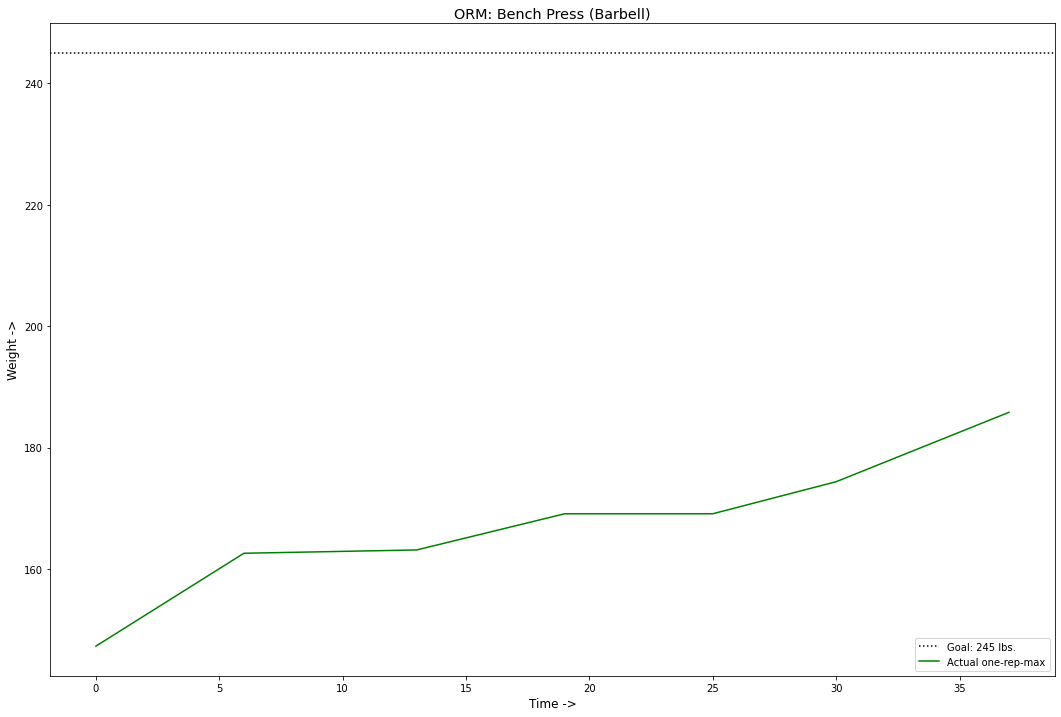

Goal: 218 lbs.
Prediction: 348 lbs.


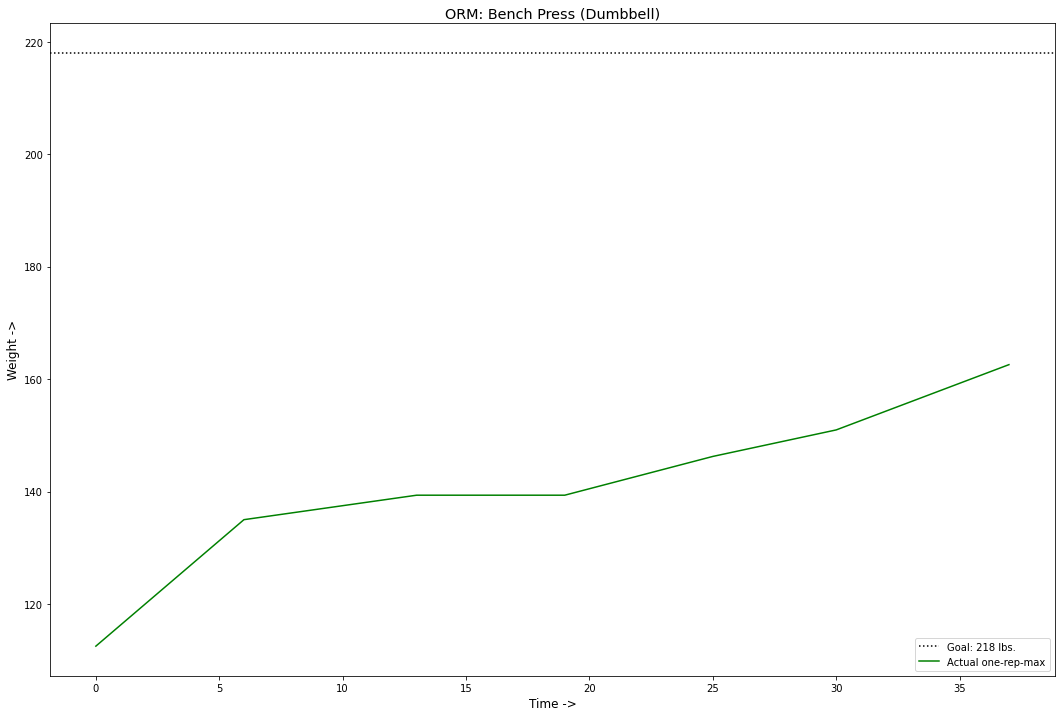

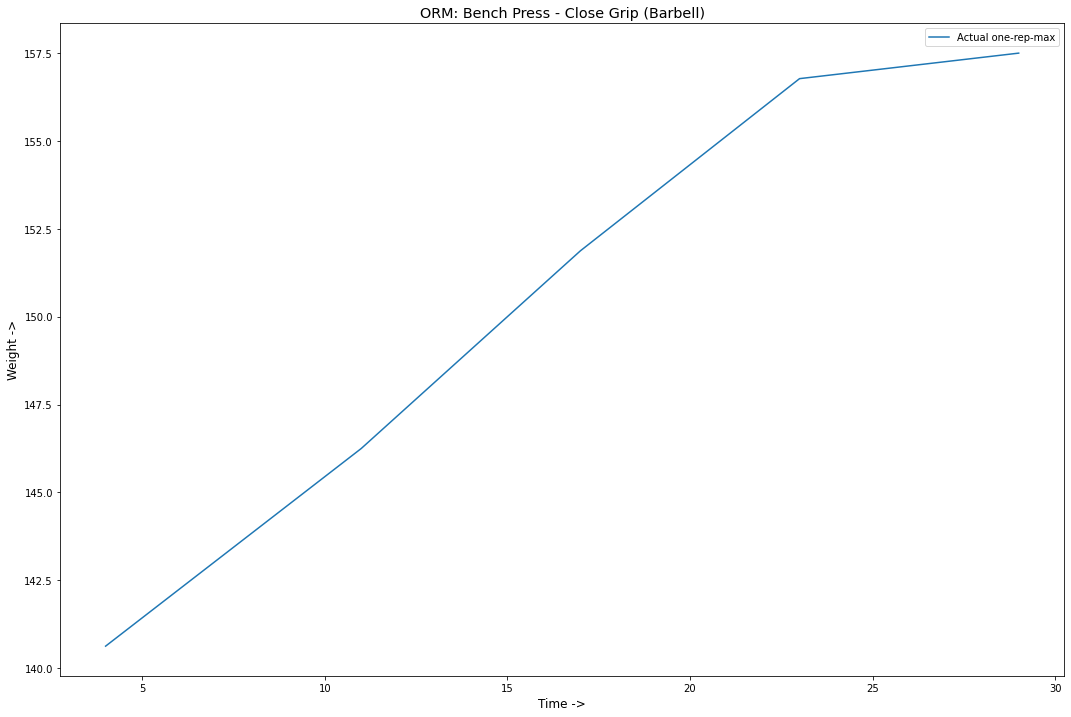

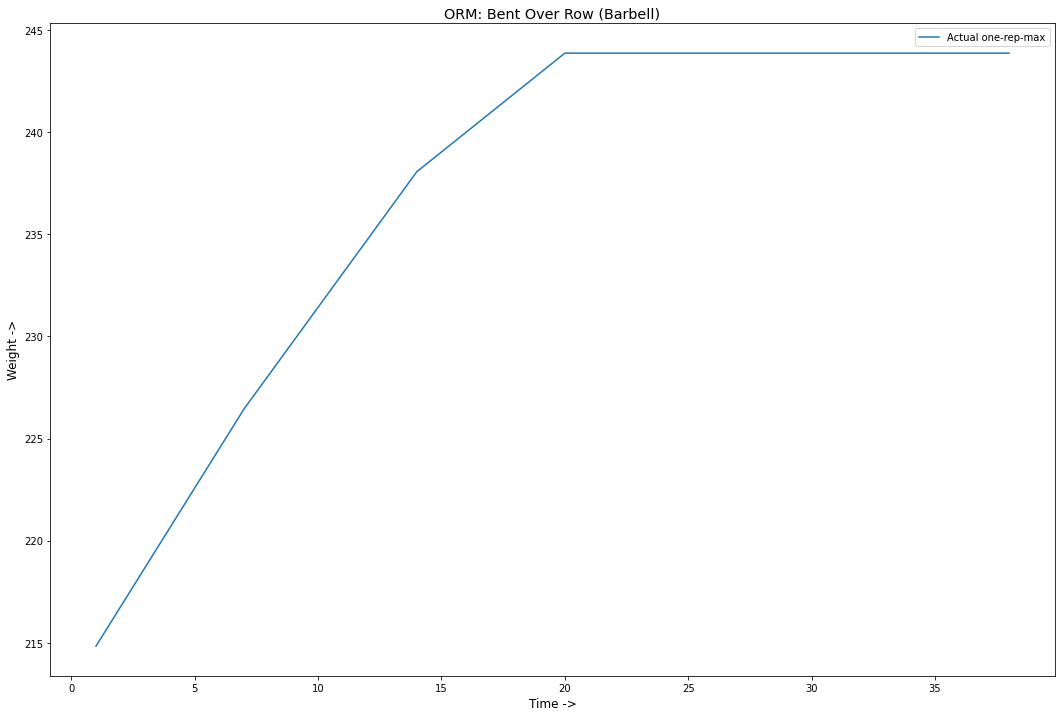

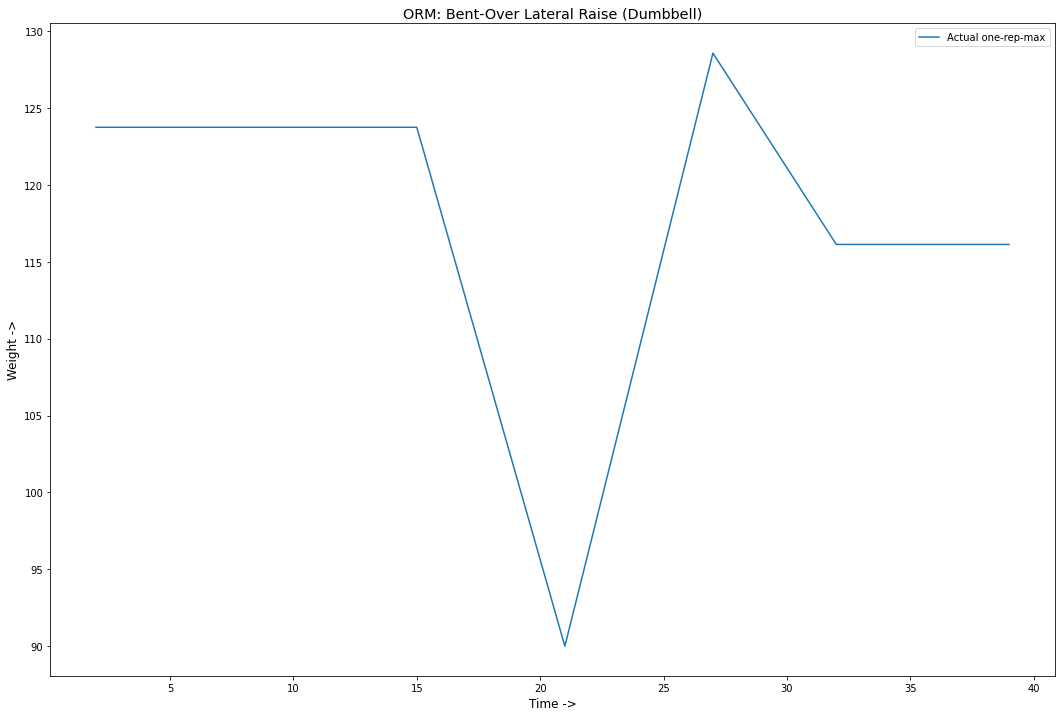

Goal: 109 lbs.
Prediction: 166 lbs.


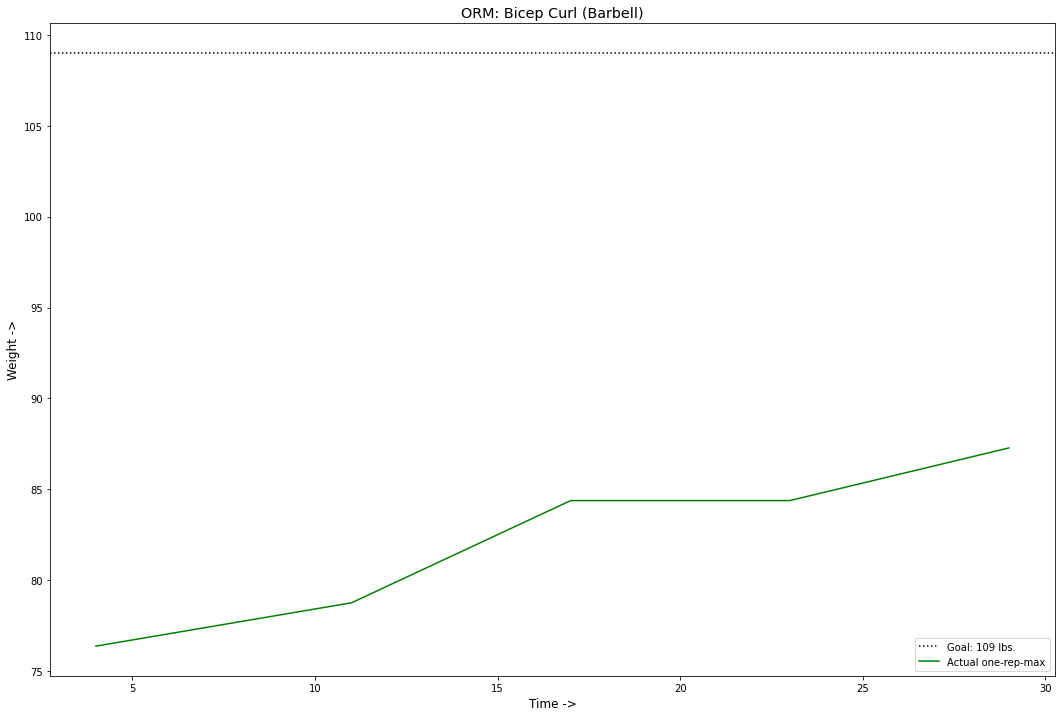

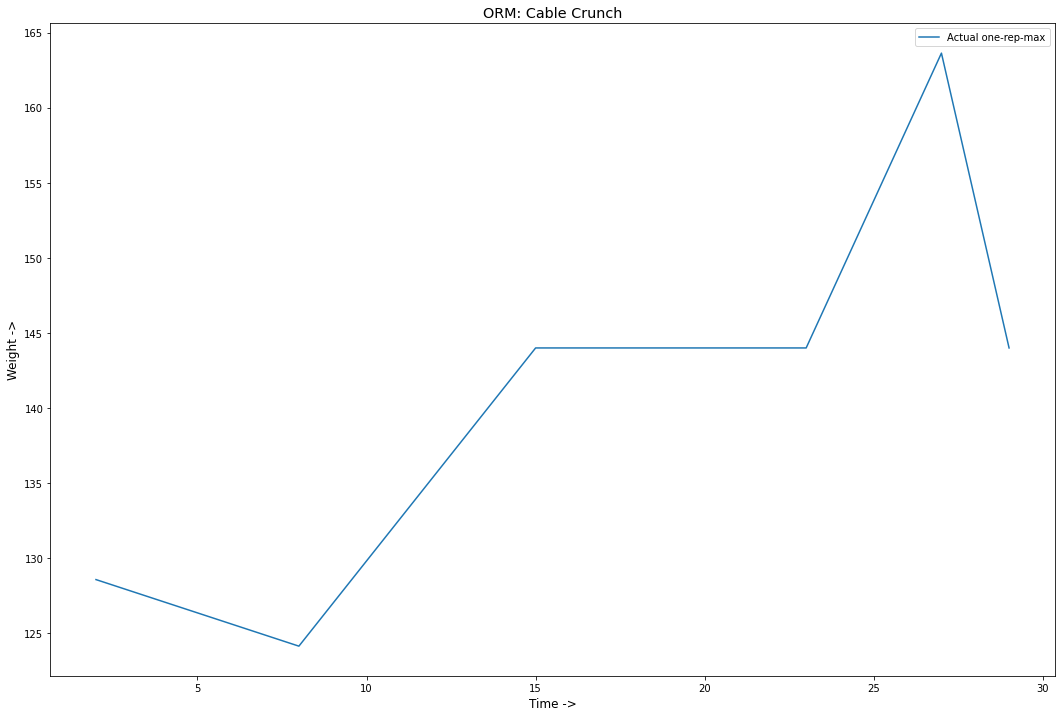

Goal: 343 lbs.
Prediction: 537 lbs.


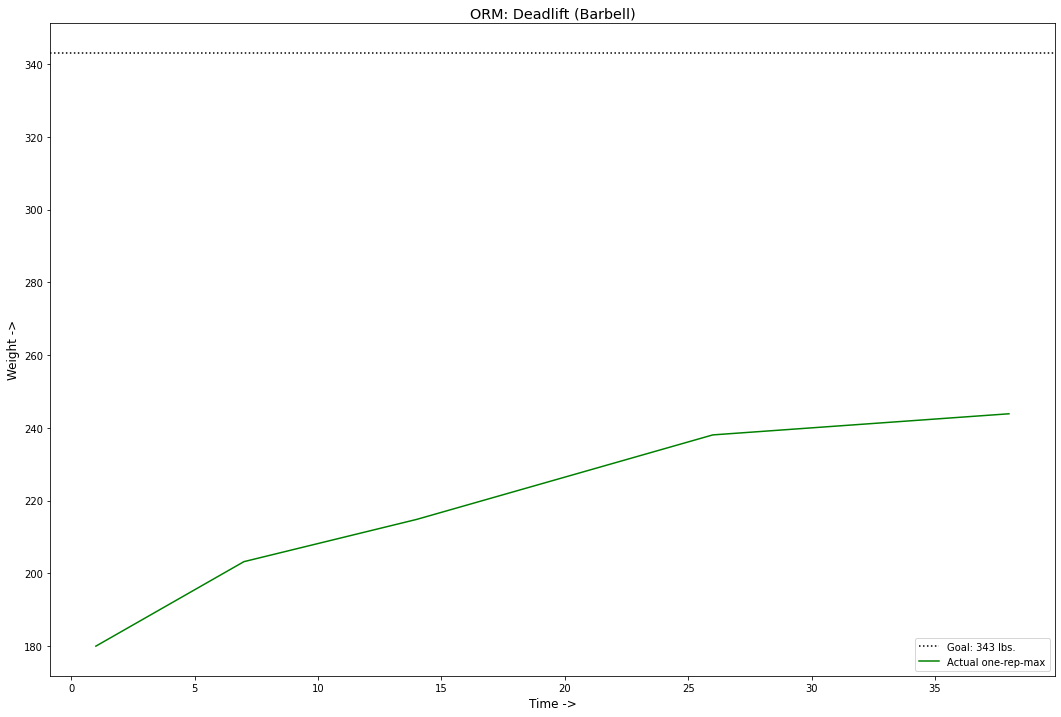

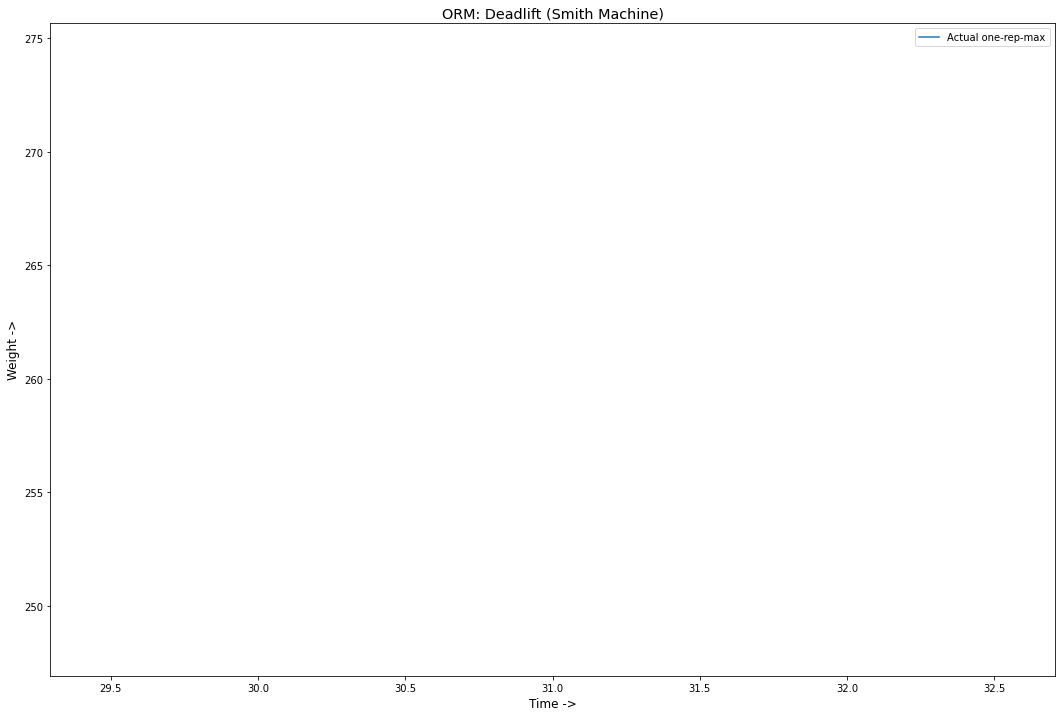

Goal: 119 lbs.
Prediction: 258 lbs.


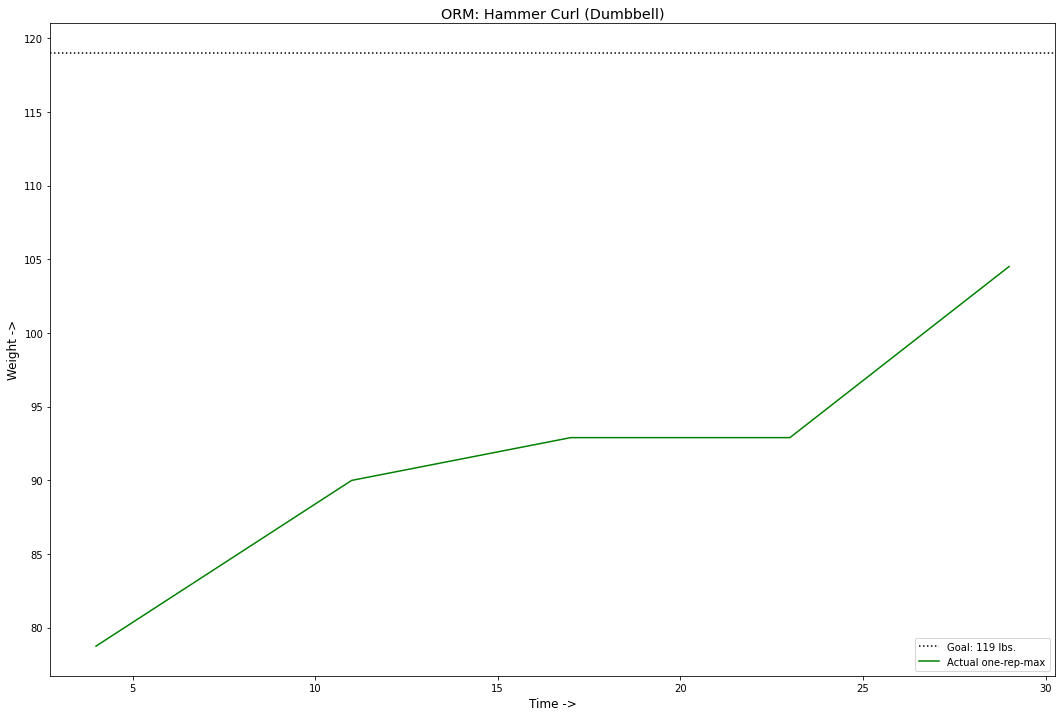

Goal: 190 lbs.
Prediction: 291 lbs.


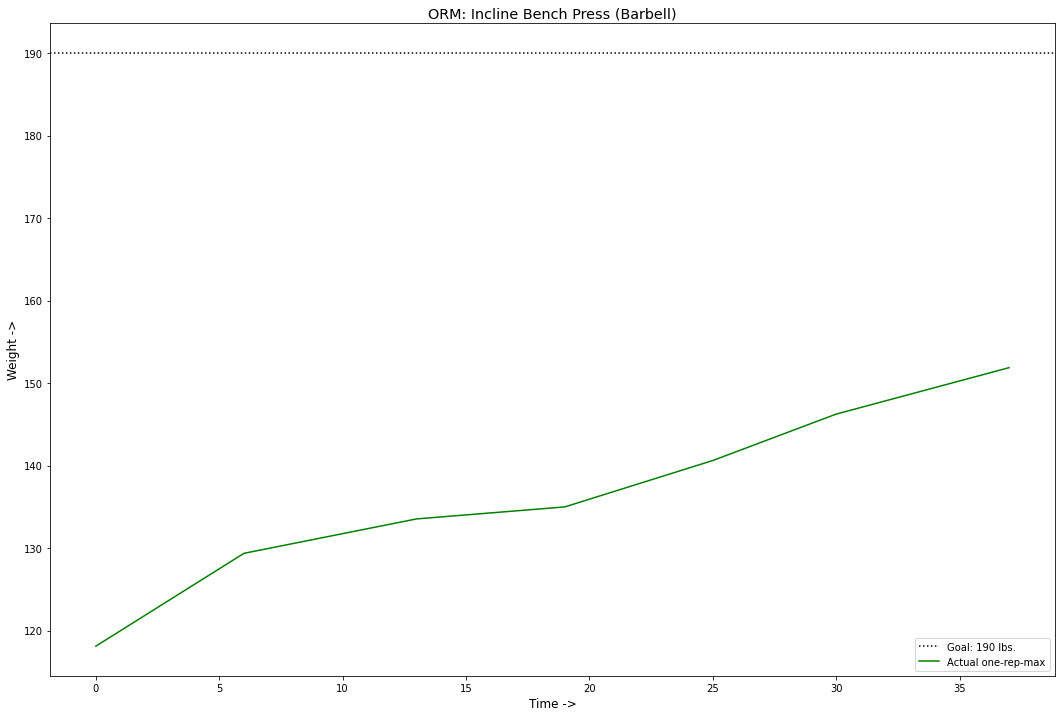

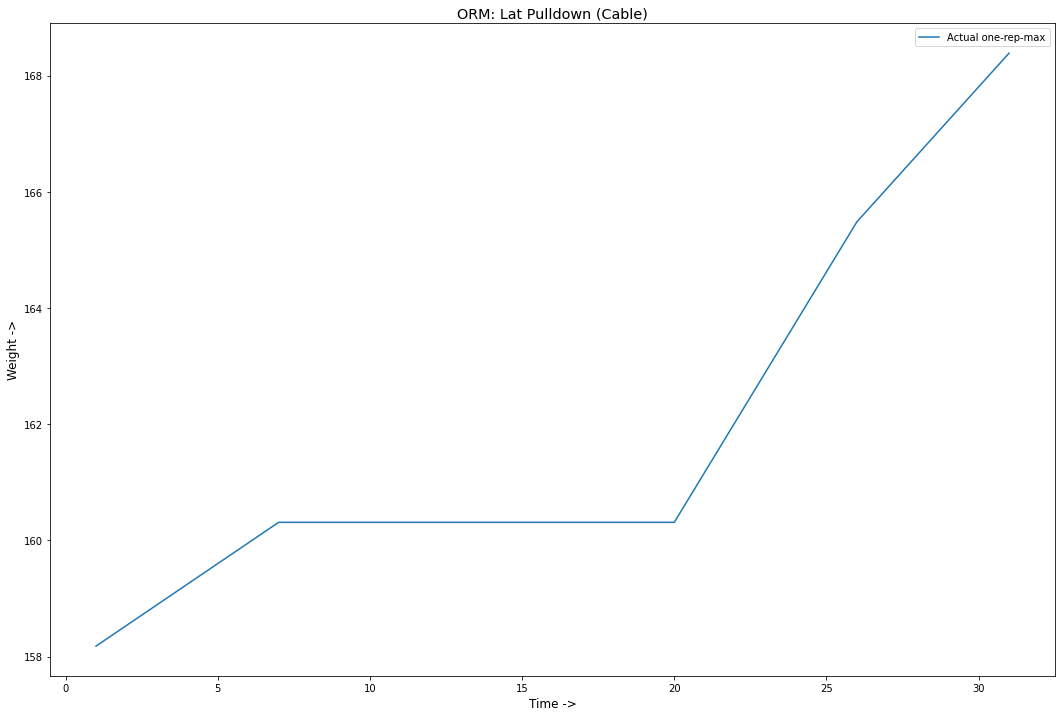

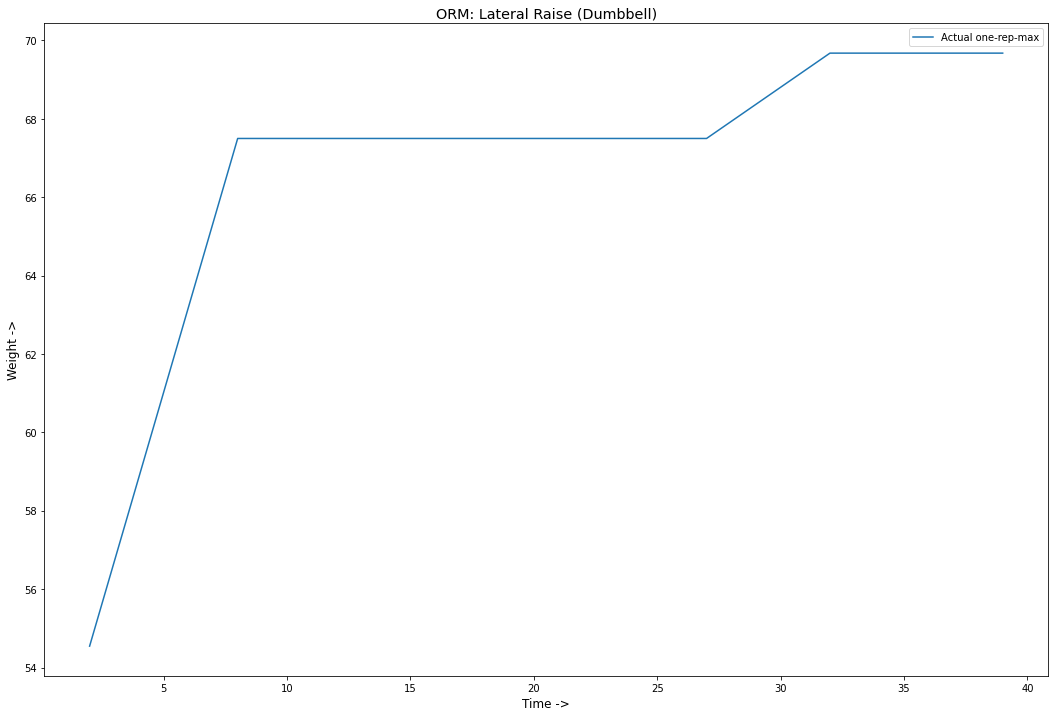

Goal: 190 lbs.
Prediction: 244 lbs.


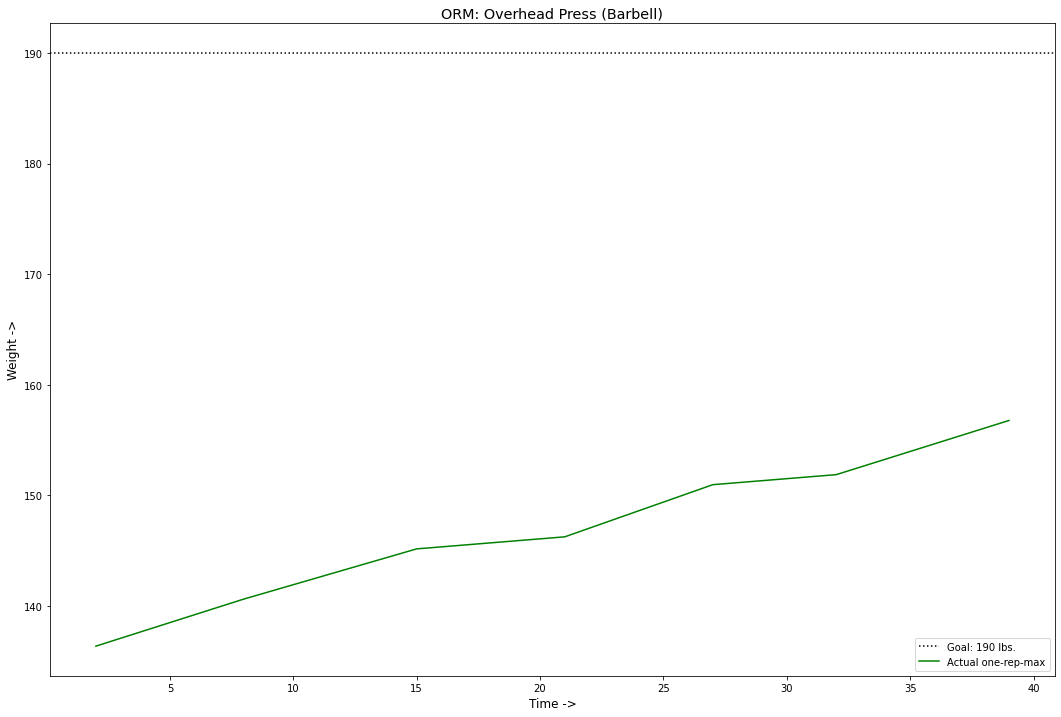

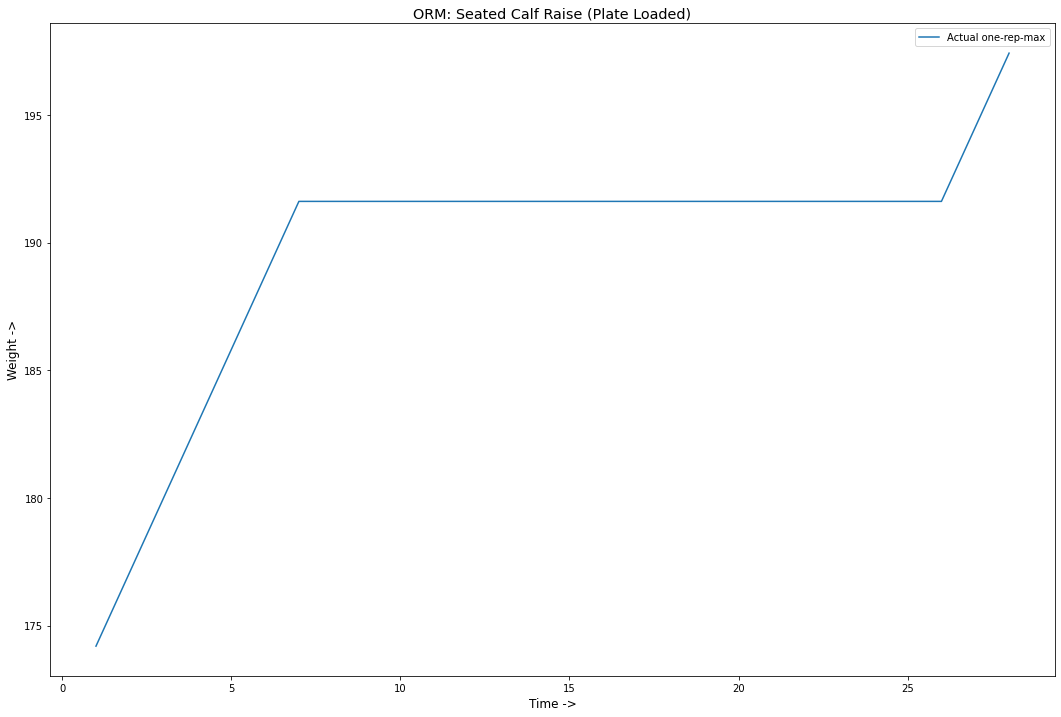

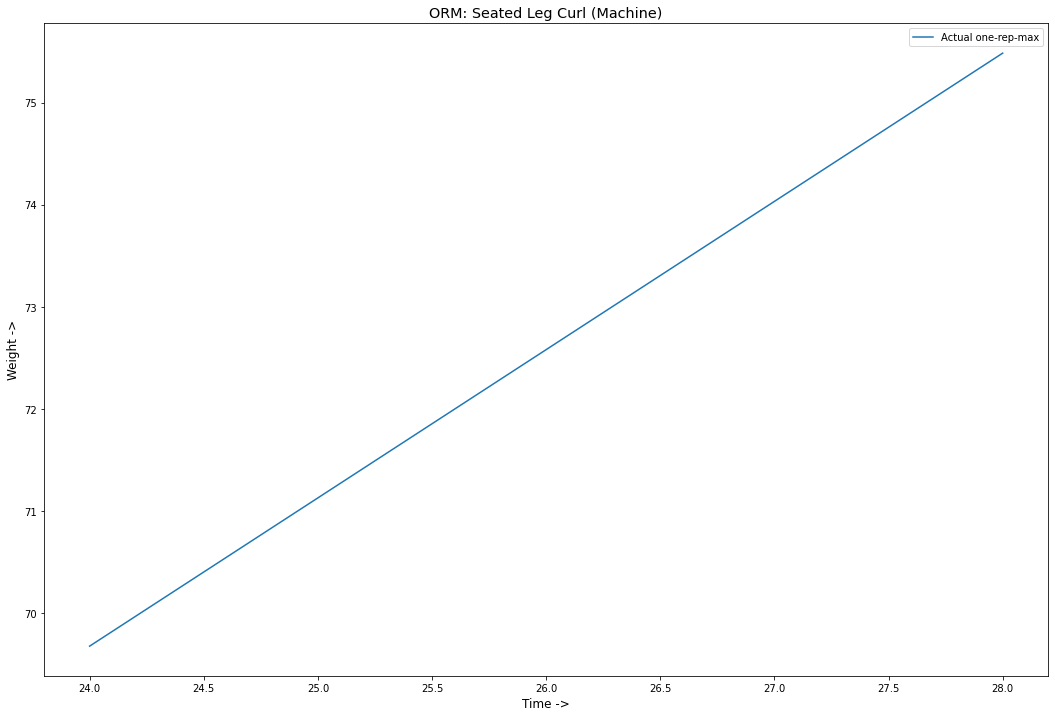

Goal: 278 lbs.
Prediction: 231 lbs.


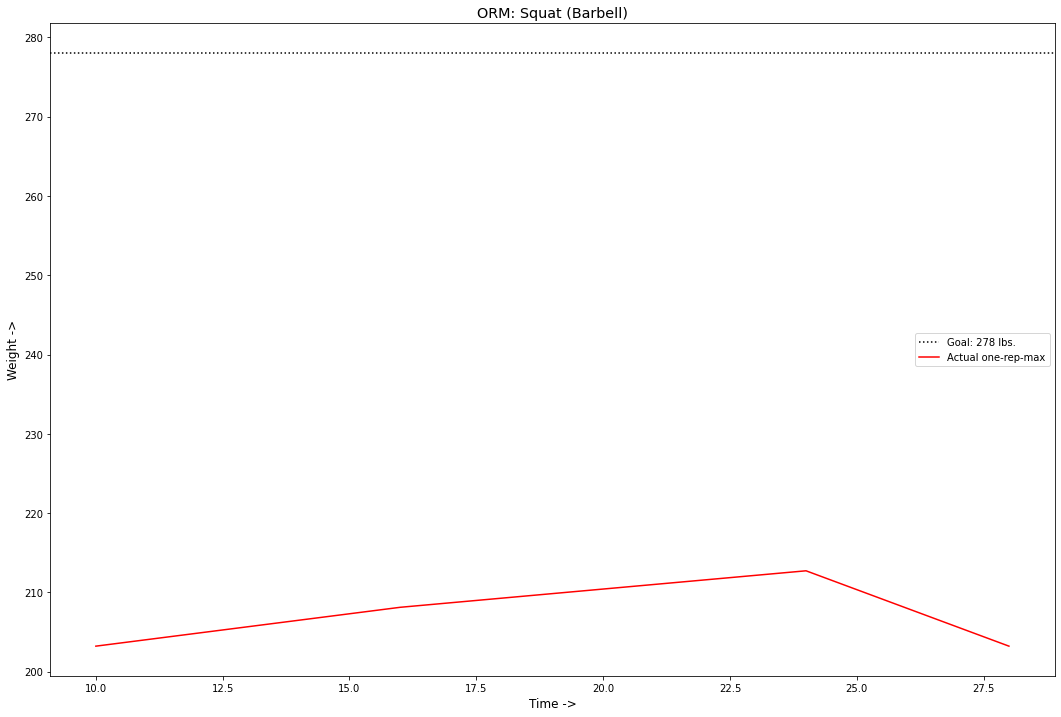

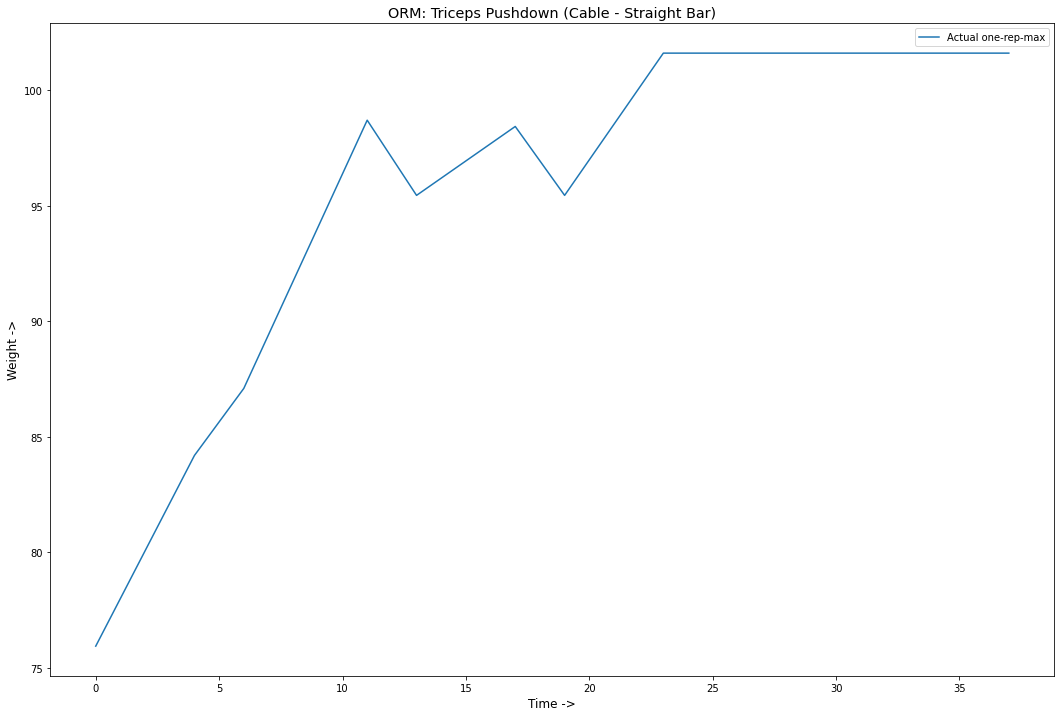

In [15]:
def graph_exercise_orm(exercise, df):
    """Draw a graph for a given exercise using the provided group data.

    Goal lines are drawn if there is a one-rep-max goal for the exercise.
    """
    f, ax = plt.subplots(1, 1)

    goal = orm_goals.get(exercise)
    if not goal:
        df.plot(ax=ax, x="days_from_start", y="ORM", title=f"ORM: {exercise}", label="Actual one-rep-max")

    else:
        X = df.days_from_start.values.reshape(-1, 1)
        Y = df.ORM.values
        model = LinearRegression().fit(X, Y)
        prediction_line = model.predict(X)
        ending_prediction = model.predict([[program_days]])

        if ending_prediction > goal:
            color = "green"
        else:
            color = "red"

        ax.axhline(y=goal, color="black", linestyle=":", label=f"Goal: {goal} lbs.")
        df.plot(ax=ax, x="days_from_start", y="ORM", title=f"ORM: {exercise}", label="Actual one-rep-max", color=color)

        # This will display *before* the graph
        print(f"Goal: {goal} lbs.")
        print(f"Prediction: {int(ending_prediction[0])} lbs.")

    ax.set_xlabel("Time ->")
    ax.set_ylabel("Weight ->")
    ax.legend()
    plt.show()


for exercise, exercise_df in orm_groups:
    header(f"{exercise} One-Rep-Max Analysis")
    graph_exercise_orm(exercise, exercise_df)
    goal = orm_goals.get(exercise)
    vertical_sep(count=4)